# CCIS Analytics Hackathon 
BombSquad (Original Name: Group O)
1. Kolla Ananta Raj - IIT Kharagpur
2. Gurugubelli Ravi Kiran - IIT Kanpur

# Handwritten word recognition (Image - to - Text) Training Pipeline

**We can break the implementation of network into following steps:**

1. Import Data

2. Data Preprocessing

3. Model Building

4. Defining Loss Function

5. Training Model

6. Decoding Outputs from Prediction

# Import Libraries

In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Intialize the variable

In [2]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

test_images = []
test_labels = []
test_input_length = []
test_label_length = []
test_original_text = []

inputs_length = []
labels_length = []

# Import Data

In [3]:

with open('words.txt') as f:
    contents = f.readlines()[18:]

lines = [line.strip() for line in contents] 
import random
random.shuffle(lines)
lines[-1]

'a05-108-05-01 ok 182 637 1682 94 47 IN by'

# Data-Preprocessing

**1. Image Pre-processing**

In [4]:
def process_image(img):
    
    w, h = img.shape
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

**2. Label-Encoding**

In [5]:
max_label_len = 0

# letters present in the labels
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


# IAM-Dataset

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        print(index)
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
      
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 >=8 :
            test_images.append(img)
            test_labels.append(label)
            test_input_length.append(31)
            test_label_length.append(len(word))
            test_original_text.append(word)
        elif index %10>=6:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)

In [7]:
len(train_images),len(train_labels)

(57924, 57924)

In [8]:
# padding the label sequences
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

test_padded_label = pad_sequences(test_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [9]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

test_images = np.asarray(test_images)
test_input_length = np.asarray(test_input_length)
test_label_length = np.asarray(test_label_length)

# Model Building

### Model Description
1. The input shape for our architecture has an input image of a height of 32 and a width of 128.
2. Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one of size (2,2). And the number of filters is increased from 64 to 512 layer by layer.
3. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
4. Also, we used batch normalization layers after each convolution layer which accelerate the training process.
5. Then we reshape output from the Conv layer and make it compatible with the LSTM layer.
6. Then we used two Bidirectional LSTM layers each of which has 256 units. This RNN layer gives the output of size (batch_size, 64, 79). Where 79 is the total number of output classes including blank characters.


In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Activation
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Concatenate, Add, Multiply, Lambda
from tensorflow.keras.layers import UpSampling2D, Reshape
from tensorflow.keras.layers import add,concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,GRU

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [11]:
def Model():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))

    drop_out_rate = 0.4
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)
    
    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)
    
    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((64,-1)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)
    
    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(len(char_list)+1, kernel_initializer='he_normal',name='dense2')(model) 
    outputs = Activation('softmax', name='softmax')(model)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs
    


In [12]:
act_model,outputs,inputs=Model()

In [13]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 128, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 32, 128, 64)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 16, 64, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 64, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 128)       512   

In [14]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

# Training Model

In [15]:
batch_size = 64
epochs = 100
e = str(epochs)
optimizer_name = 'adam'

In [16]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)
callbacks_list = [checkpoint, early_stop]


In [17]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/100
906/906 [==============================] - 103s 103ms/step - loss: 13.7702 - accuracy: 0.0346 - val_loss: 9.6100 - val_accuracy: 0.1766

Epoch 00001: val_accuracy improved from -inf to 0.17660, saving model to adamo-100e-57924t-19287v.hdf5
Epoch 2/100
906/906 [==============================] - 92s 101ms/step - loss: 8.4297 - accuracy: 0.1926 - val_loss: 7.5924 - val_accuracy: 0.2229

Epoch 00002: val_accuracy improved from 0.17660 to 0.22295, saving model to adamo-100e-57924t-19287v.hdf5
Epoch 3/100
906/906 [==============================] - 92s 102ms/step - loss: 6.3964 - accuracy: 0.2795 - val_loss: 6.1089 - val_accuracy: 0.3123

Epoch 00003: val_accuracy improved from 0.22295 to 0.31228, saving model to adamo-100e-57924t-19287v.hdf5
Epoch 4/100
906/906 [==============================] - 92s 102ms/step - loss: 5.0653 - accuracy: 0.3397 - val_loss: 5.0737 - val_accuracy: 0.3629

Epoch 00004: val_accuracy improved from 0.31228 to 0.36289, saving model to adamo-100e-57924t-1

In [18]:
model.save(filepath='./model_AB_BS64_FULL.h5', overwrite=True, include_optimizer=True)

# Performance check

For computing the performance, We will be using the **Jaro-Winkler** algorithm to detect similarity between the captured text and the actual text.

In [19]:

# filepath='adamo-100e-57924t-19287v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))


jaro : 0.9306504488427468


In [1]:
# filepath='adamo-100e-57924t-19287v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(test_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, test_original_text[i])

print('jaro :', total_jaro/len(out))

jaro : 0.9296586950035265


In [21]:
def accuracies(model,test_images,test_labels):
    
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    
    prediction = model.predict(test_images)
    
    # use CTC decoder
    decoded = K.ctc_decode(prediction,   
                           input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                           greedy=True)[0][0]

    out = K.get_value(decoded)
    predicted_labels = []
    for _, x in enumerate(out):
        s = ''
        for p in x:
            if int(p) != -1:
                s = s+char_list[int(p)]
        predicted_labels.append(s)
        
    
    for i in range(len(test_labels)):
        predicted_output=predicted_labels[i]
        actual_output=test_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
    final_accuracy=np.round((accuracy/len(test_labels))*100,2)
    final_letter_acc=np.round((letter_acc/letter_cnt)*100,2)
    
    return final_accuracy,final_letter_acc

In [22]:
accuracy,letter_acc = accuracies(act_model, valid_images, valid_original_text)
print("Validation Average Word Accuracy : ",np.round(accuracy,2)," %")
print("Validation Average Letter Accuracy ",np.round(letter_acc,2)," %")

Validation Average Word Accuracy :  71.72  %
Validation Average Letter Accuracy  78.25  %


In [30]:
accuracy,letter_acc = accuracies(act_model, test_images, test_original_text)
print("Testing Average Word Accuracy : ",np.round(accuracy,2)," %")
print("Testing Average Letter Accuracy ",np.round(letter_acc,2)," %")

Testing Average Word Accuracy :  71.02  %
Testing Average Letter Accuracy  77.76  %


# Visualization of Loss and Acurracy

In [35]:
#plot accuracy and loss
def plotgraph(epochs, acc, val_acc, name):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.title(name)
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [36]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)


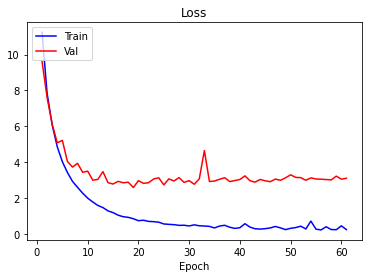

In [37]:
plotgraph(epochs, loss, val_loss, 'Loss')

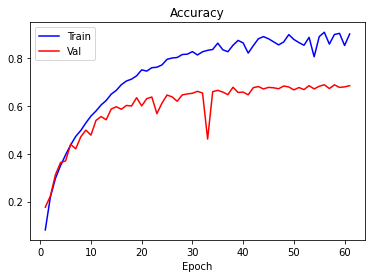

In [38]:
plotgraph(epochs, acc, val_acc, 'Accuracy')